In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import load_img
from keras import callbacks
from keras.callbacks import History
from tensorflow.data import Dataset

import os
import matplotlib.pyplot as plt
import numpy as np

import time
from datetime import timedelta
from tqdm import tqdm

In [2]:
DATA_PATH = "../../Data/"

IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_shrinked/"

IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated/"
#IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

In [3]:
SAVING_ON = True

In [52]:
def compile_model(input_shape: tuple, num_classes: int): #-> Sequential:
    
    dropout_rate = 0.3
    
    '''
    convolutions = [
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu")
    ]
    ''';
    
    
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=(112,150,3)),
         
        layers.Conv2D(16, 5, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(32, 5, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, 5, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
                
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"]) #, run_eagerly=True)
    return model #, convolutions


'''
# GOOD MODEL ACC>90 VAL_ACC>78 160s/epoch

def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        #data_augmentation,
        layers.Resizing(112,150),
        layers.Rescaling(1./255, input_shape=input_shape),
        
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Conv2D(16, 1, padding='same', activation="relu"),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 1, padding='same', activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 1, padding='same', activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 1, padding='same', activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model



''';

'''
# ORIGINAL
def compile_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        #data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(32, 3, padding='same', activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model

''';

In [5]:
def fit_model(model: Sequential, train_ds: Dataset, test_ds: Dataset, 
              epochs: int=10, augment: str="no_augment", verbose: bool=True):
    global SAVING_ON
    
    # explanation of Early Stopping is below in next section(s)
    trigger = callbacks.EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.001,
                                      patience=15, restore_best_weights=True)

    history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, callbacks=[trigger])
    epochs = len(history.history['loss'])
    print("Epoch Length        : {0}".format(epochs))
    
    if verbose:
        evaluate_model(model, train_ds, test_ds)
        print_training_history(history, epochs)
    
    if SAVING_ON:
        model.save("output\keras_models\skin_classifier_{0}_{1}.keras".format(epochs, augment))

In [6]:
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset):
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))

In [7]:
def print_training_history(history: History, epochs: int):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

In [8]:
img_size = (450, 600) # keep original size, not 255x255
epochs = 5

start_time = time.time()

image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_PATH_SEPARATED,
    image_size=img_size,
    batch_size=32,
    shuffle=True
)

for images, labels in image_ds:
    model_input_shape = images.shape
    break
    
class_names = image_ds.class_names
num_classes = len(class_names)

statistics_data = [[],[],[],[]]

total_folds = 5 # 5
total_size = len(image_ds) 
fold_size = int(total_size / total_folds) 

if False:
    for i in tqdm(range(0, total_folds)): 
        print(" --- KFold Iteration {0} --- ".format(i+1))
        # split data looks strange but all it does 
        # it splits and shifts every iteration of the loop
        train_d_head = image_ds.take(i*fold_size)  
        rest_d = image_ds.skip(i*fold_size)
        test_d = rest_d.take(fold_size)
        train_d_tail = rest_d.skip(fold_size)
        train_d = train_d_head.concatenate(train_d_tail)

        test_d = test_d.prefetch(buffer_size=32)
        train_d = train_d.prefetch(buffer_size=32)

        model = compile_model(model_input_shape[1:], num_classes)  # todo remove input shape
        fit_model(model, train_d, test_d, epochs, verbose=True, 
                  augment="kfold_{0}".format(i+1))

        # gather statistics
        train_evaluation = model.evaluate(train_d, verbose=0)
        validation_evaluation = model.evaluate(test_d, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

    print(" === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))



Found 9013 files belonging to 7 classes.


In [9]:
'''
ValueError: Unexpected result of `train_function` (Empty logs). 
Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` 
for more information of where went wrong, or file a issue/bug to `tf.keras`.
''';

## Next KFold iterations might take longer (epoch time)
## add axis titles

Found 9013 files belonging to 7 classes.
Epoch 1/5
225/225 [==============================] - 100s 441ms/step - loss: 1.1243 - accuracy: 0.6661 - val_loss: 1.0320 - val_accuracy: 0.6586
Epoch 2/5
225/225 [==============================] - 97s 428ms/step - loss: 0.9707 - accuracy: 0.6742 - val_loss: 0.9838 - val_accuracy: 0.6553
Epoch 3/5
225/225 [==============================] - 99s 439ms/step - loss: 0.9294 - accuracy: 0.6757 - val_loss: 0.9059 - val_accuracy: 0.6669
Epoch 4/5
225/225 [==============================] - 100s 443ms/step - loss: 0.9023 - accuracy: 0.6785 - val_loss: 0.9034 - val_accuracy: 0.6597
Epoch 5/5
225/225 [==============================] - 107s 475ms/step - loss: 0.8626 - accuracy: 0.6815 - val_loss: 0.8817 - val_accuracy: 0.6762
Epoch Length        : 5
Model Accuracy      : 0.7072
Validation Accuracy : 0.6801


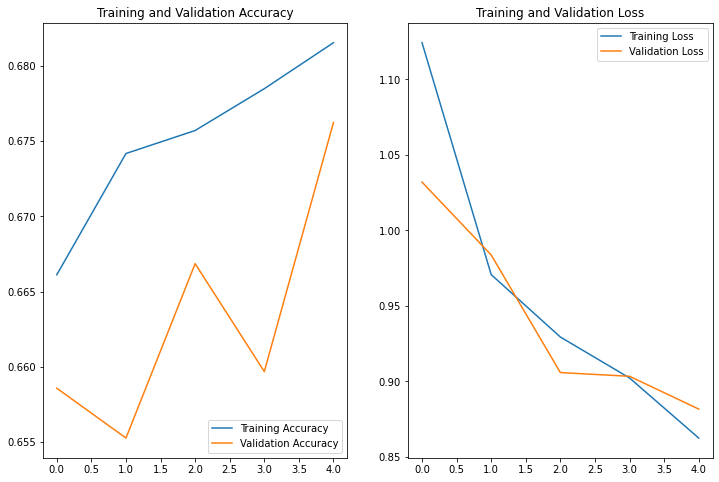

In [53]:
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_PATH_SEPARATED,
    image_size=img_size,
    batch_size=32,
    shuffle=True
)

epochs = 5
split = int(len(image_ds)*0.8)
train_d = image_ds.take(split)  
test_d = image_ds.skip(split)

model = compile_model(model_input_shape[1:], num_classes)  # todo remove input shape
fit_model(model, train_d, test_d, epochs, verbose=True, 
          augment="testing_{0}".format(epoches))

In [49]:
# 2, 5, 8
model.layers

In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 112, 150, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 112, 150, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 150, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 56, 75, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 56, 75, 64)        18496     
                                                      

In [ ]:
x1w = model.layers[8].get_weights()[0][:,:,0,:]
for i in range(1,64):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

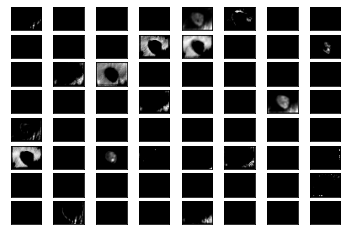

In [51]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot

# redefine model to output right after the first hidden layer
model_t = keras.Model(inputs=model.inputs, outputs=model.layers[8].output)
img = load_img('input/ISIC_0024891.jpg', target_size=(450, 600))

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)

feature_maps = model_t.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

In [ ]:
# NOT NEEDED

# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()


# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)




In [ ]:
if not;

ann = Sequential()
x = layers.Conv2D(filters=64,kernel_size=(5,5),input_shape=(32,32,3))
ann.add(x)
ann.add(layers.Activation("relu"))

x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

ann.fit(Xtrain, ytrain_indicator, epochs=5, batch_size=32)

x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [ ]:
'''
Time it initially took to train a network was 462s per epoch
with reduction of image size and changing layers slightly it was down to 60s
462s -> 458s
217s -> 219s    Images halfed
184s -> 186s  
125s -> 123s    Images quortered
166s -> 157s 
77s  -> 60s     Network simplified, 5 KFolds instead of 10 KFolds
44s  -> 40s     Added first layer

Here beta 1 with overfitting example graph
Reducing number of learning parameters, Dropout used
TODO Look at loss and cost function

smaller data 1.43GB
35s -> 33s  ACC 53 VAL 53
''';